In [1]:
# Game imports
import sys
import os
sys.path.insert(0,'..')
from open_spiel.python import rl_environment

import torch
from torch.distributions import Categorical

import numpy as np

from markov_soccer.networks import policy
from markov_soccer.networks import critic
import matplotlib.pyplot as plt

from copg_optim.critic_functions import critic_update, get_advantage
from markov_soccer.soccer_state import get_relative_state, get_two_state

import scipy.io

In [2]:
p1 = policy(12,5)
p2 = policy(12,5)

num_episode = 5000

game = "markov_soccer"
num_players = 2

env = rl_environment.Environment(game)
num_actions = env.action_spec()["num_actions"]
#print(num_actions)

In [3]:
def compete(player1,player2): 
    p1.load_state_dict(torch.load("../markov_soccer/pretrained_models/" + player1 + ".pth"))
    p2.load_state_dict(torch.load("../markov_soccer/pretrained_models/" + player2 + ".pth"))
    win_mat=[]
    ball_status = [] #0 ball with A and A scored, 1, ball with B and b scored, 2 is ball with A and B scored, 3 is ball with B and A scored
    originality_status = []
    game_length = []
    for t_eps in range(num_episode):
        mat_action = []

        mat_state1 = []
        mat_reward1 = []
        mat_done = []

        mat_state2 = []
        mat_reward2 = []
        time_step = env.reset()
        _,_,rel_state = get_relative_state(time_step)
        pre_a_status, pre_b_status, rel_state1, rel_state2 = get_two_state(time_step)
        state = time_step.observations["info_state"][0]
        i=0
    #     if t_eps % 100 == 0:
    #         win_array = np.array(win_mat)
    #         print(np.sum(win_array == 0), np.sum(win_array == 1), np.sum(win_array == 2))
        temp_ball_stat = 0
        originality = 0

        #data_collection
        while time_step.last()==False:
            action1_prob = p1(torch.FloatTensor(rel_state1))
            dist1 = Categorical(action1_prob)
            action1 = dist1.sample()

            action2_prob = p2(torch.FloatTensor(rel_state2))
            dist2 = Categorical(action2_prob)
            action2 = dist2.sample()

            action = np.array([action1, action2])

            time_step = env.step(action)
            _,_,rel_state = get_relative_state(time_step)
            a_status, b_status, rel_state1, rel_state2 = get_two_state(time_step)

            if pre_a_status ==0 and a_status ==1:
                #print('a got the ball')
                if temp_ball_stat%2==0 and temp_ball_stat!=0: # B had the ball, but A took it
                    temp_ball_stat = temp_ball_stat + 1
                else:
                    temp_ball_stat = 1 # A got the ball
                    originality = 1

            if pre_b_status ==0 and b_status ==1:
                #print('b got the ball')
                if temp_ball_stat%2==1:
                    temp_ball_stat = temp_ball_stat + 1 # B snatched the ball
                else:
                    temp_ball_stat = 2
                    originality = 2

            pre_a_status = a_status
            pre_b_status = b_status

            reward1 = time_step.rewards[0]
            reward2 = time_step.rewards[1]

            if time_step.last() == True:
                done = True
            else:
                done=False

            i=i+1
            if done == True:
                temp=0
                if reward1>0:
                    temp=1
                    #print("a won")
                if reward2>0:
                    temp=2
                    #print("b won")
                if originality ==1: #A got the ball initially
                    if temp_ball_stat>1: # Finally B scored the goal or A scored the goal after taking ball from b
                        temp_ball_stat = temp_ball_stat + 2
                if temp ==0 and temp_ball_stat is not 0:
                    temp_ball_stat = 0 # no one score goal
                ball_status.append(temp_ball_stat)
                originality_status.append(originality)
                win_mat.append(temp)
                #print(state1, state2, reward1,reward2, done)
                break
    return ball_status, win_mat

In [4]:
def play_matches(Algo1_P1,Algo1_P2,Algo2_P1,Algo2_P2):
    algo11_bs, algo11_wm = compete(Algo1_P1,Algo1_P2)
    algo22_bs, algo22_wm = compete(Algo2_P1,Algo2_P2)
    algo12_bs, algo12_wm = compete(Algo1_P1,Algo2_P2)
    algo21_bs, algo21_wm = compete(Algo2_P1,Algo1_P2)

    fig, (ax1,ax2,ax3,ax4) = plt.subplots(1,4,figsize=(18,3))
    data = np.bincount(algo11_bs)/np.sum(np.bincount(algo11_bs))
    if data[0] == 0:
        ax1.bar(['$A_1$','$B_1$','$A_2$','$B_2$','$A_3$','$B_3$'], data[1:7], width=0.9, align='center')
    else:
        ax1.bar(['N','$A_1$', '$B_1$', '$A_2$', '$B_2$', '$A_3$', '$B_3$'], data[0:7], width=0.9,
               align='center')
    ax1.set_title(Algo1_P1 + ' vs ' + Algo1_P2)
    data = np.bincount(algo22_bs)/np.sum(np.bincount(algo22_bs))
    if data[0] == 0:
        ax2.bar(['$A_1$','$B_1$','$A_2$','$B_2$','$A_3$','$B_3$'], data[1:7], width=0.9, align='center')
    else:
        ax2.bar(['N','$A_1$', '$B_1$', '$A_2$', '$B_2$', '$A_3$', '$B_3$'], data[0:7], width=0.9,
               align='center')
    ax2.set_title(Algo2_P1 + ' vs ' + Algo2_P2)
    data = np.bincount(algo12_bs)/np.sum(np.bincount(algo12_bs))
    if np.size(data)>6:
        if data[0] == 0:
            ax3.bar(['$A_1$','$B_1$','$A_2$','$B_2$','$A_3$','$B_3$'], data[1:7], width=0.9, align='center')
        else:
            ax3.bar(['N','$A_1$', '$B_1$', '$A_2$', '$B_2$','$A_3$','$B_3$'], data[0:7], width=0.9,
                   align='center')
    else:            
        if data[0] == 0:
            ax3.bar(['$A_1$','$B_1$','$A_2$','$B_2$'], data[1:5], width=0.9, align='center')
        else:
            ax3.bar(['N','$A_1$', '$B_1$', '$A_2$', '$B_2$'], data[0:5], width=0.9,
                   align='center')
    ax3.set_title(Algo1_P1 + ' vs ' + Algo2_P2)
    w=0.45
    wm12 = np.array(algo12_wm)
    wm21 = np.array(algo21_wm)
    w1_12 = np.sum(wm12 == 1)/np.size(wm12)
    w2_12 = np.sum(wm12 == 2)/np.size(wm12)
    w1_21 = np.sum(wm21 == 1)/np.size(wm12)
    w2_21 = np.sum(wm21 == 2)/np.size(wm12)
    if w1_12>w2_12:
        pl1 = Algo1_P1
    else:
        pl1 = Algo2_P2
    if w1_21>w2_21:
        pl2 = Algo2_P1
    else:
        pl2 = Algo1_P2
    labels = ['Game1:' + pl1,'Game2:' + pl2]
    x = np.arange(len(labels))
    ax4.bar(x - w/2, [w1_12,w2_12],w*0.95, label='A')
    ax4.bar(x + w/2, [w1_21,w2_21],w*0.95, label='B')
    ax4.set_xticks(x)
    ax4.set_xticklabels(labels)
    ax4.set_title('Win plot')
    plt.legend()
    plt.show()

### CoPG vs GDA

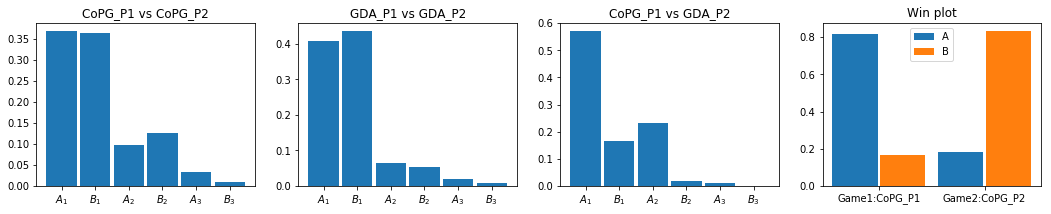

In [5]:
Algo1_P1 = 'CoPG_P1'
Algo1_P2 = 'CoPG_P2'
Algo2_P1 = 'GDA_P1'
Algo2_P2 = 'GDA_P2'
play_matches(Algo1_P1,Algo1_P2,Algo2_P1,Algo2_P2)

### TRCoPO vs TRGDA

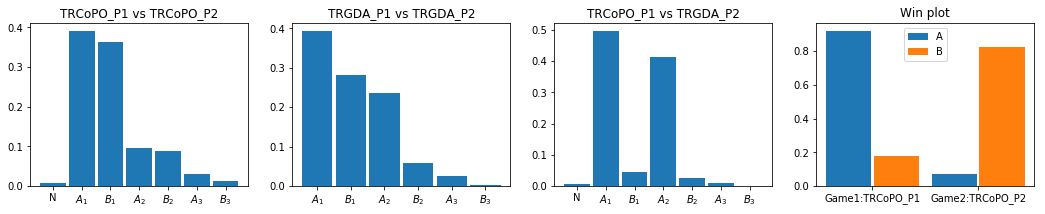

In [6]:
Algo1_P1 = 'TRCoPO_P1'
Algo1_P2 = 'TRCoPO_P2'
Algo2_P1 = 'TRGDA_P1'
Algo2_P2 = 'TRGDA_P2'
play_matches(Algo1_P1,Algo1_P2,Algo2_P1,Algo2_P2)

### CoPG vs TRGDA

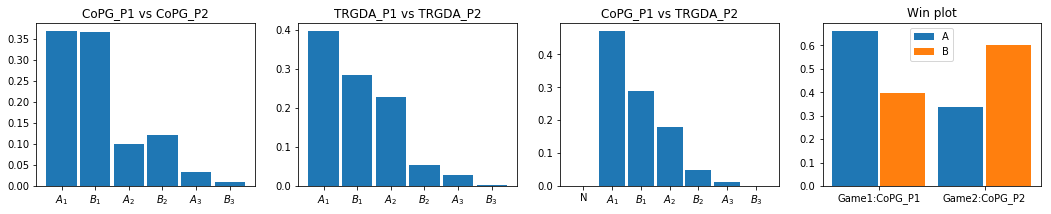

In [7]:
Algo1_P1 = 'CoPG_P1'
Algo1_P2 = 'CoPG_P2'
Algo2_P1 = 'TRGDA_P1'
Algo2_P2 = 'TRGDA_P2'
play_matches(Algo1_P1,Algo1_P2,Algo2_P1,Algo2_P2)

### CoPG vs TRCoPO

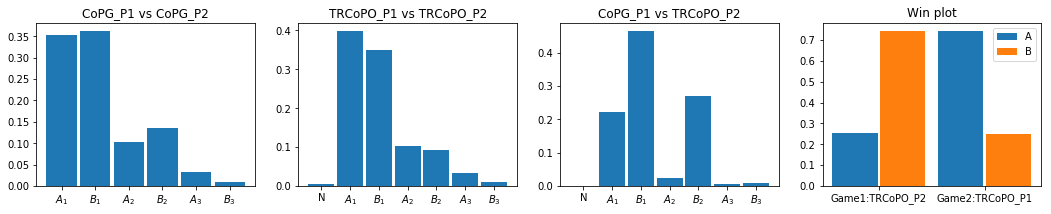

In [8]:
Algo1_P1 = 'CoPG_P1'
Algo1_P2 = 'CoPG_P2'
Algo2_P1 = 'TRCoPO_P1'
Algo2_P2 = 'TRCoPO_P2'
play_matches(Algo1_P1,Algo1_P2,Algo2_P1,Algo2_P2)

### CoPG vs MADDPG

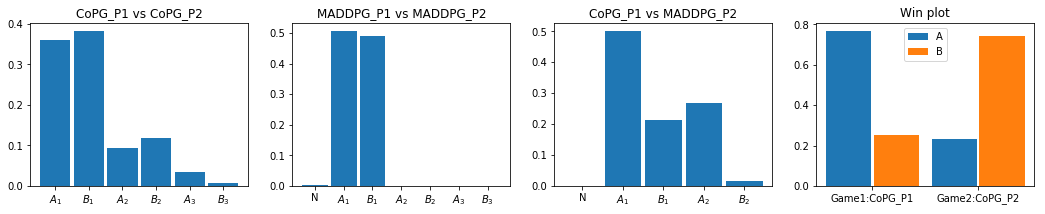

In [10]:
Algo1_P1 = 'CoPG_P1'
Algo1_P2 = 'CoPG_P2'
Algo2_P1 = 'MADDPG_P1'
Algo2_P2 = 'MADDPG_P2'
play_matches(Algo1_P1,Algo1_P2,Algo2_P1,Algo2_P2)

### TRGDA vs GDA

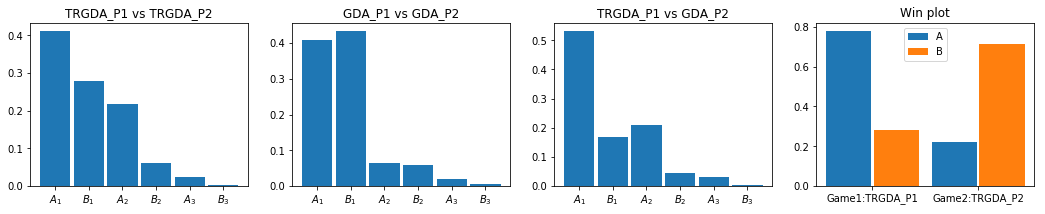

In [11]:
Algo1_P1 = 'TRGDA_P1'
Algo1_P2 = 'TRGDA_P2'
Algo2_P1 = 'GDA_P1'
Algo2_P2 = 'GDA_P2'
play_matches(Algo1_P1,Algo1_P2,Algo2_P1,Algo2_P2)

### TRCoPO vs GDA

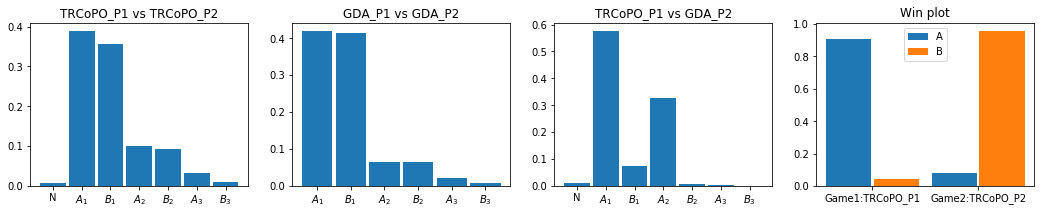

In [12]:
Algo1_P1 = 'TRCoPO_P1'
Algo1_P2 = 'TRCoPO_P2'
Algo2_P1 = 'GDA_P1'
Algo2_P2 = 'GDA_P2'
play_matches(Algo1_P1,Algo1_P2,Algo2_P1,Algo2_P2)